Example authorship comming from: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb 

# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import transforms

import torch.nn.functional as F

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Load our test image and see how it looks.

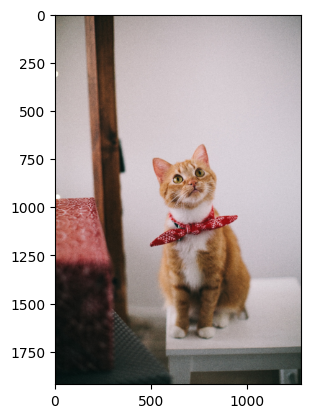

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('data/cat.png')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])      
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 available in Pytorch.

In [4]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Get the predicition for our image.

In [6]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.
(Load label texts for ImageNet predictions so we know what model is predicting)


In [37]:
from utils.utils import get_class_name_imagenet
probs = F.softmax(logits, dim=1).squeeze()
p, c = probs.topk(5)
[print("Class ***{}*** (idx:{}) has probability: {:.3f}".format(get_class_name_imagenet(c[_i]),c[_i],p[_i])) for _i in range(p.shape[0])]

Class ***tiger cat*** (idx:282) has probability: 0.186
Class ***tabby*** (idx:281) has probability: 0.078
Class ***Egyptian cat*** (idx:285) has probability: 0.021
Class ***bow tie*** (idx:457) has probability: 0.016
Class ***toy poodle*** (idx:265) has probability: 0.011


[None, None, None, None, None]

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [12]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():   
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])  
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [13]:
def batch_predict(images):
    with torch.no_grad():
        batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        batch = batch.to(device)
        
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [14]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

282

Import lime and create explanation for this prediciton.

In [25]:
from lime import lime_image

# Inherits from scikit-image: https://github.com/marcotcr/lime/blob/master/lime/wrappers/scikit_image.py
# Check segmentation algorithms: https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.felzenszwalb
from lime.wrappers.scikit_image import SegmentationAlgorithm 


In [65]:
explainer = lime_image.LimeImageExplainer() #https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image
segmenter = SegmentationAlgorithm('slic',n_segments=100) 

explanation = explainer.explain_instance(image=np.array(pill_transf(img)), 
                                         classifier_fn=batch_predict, # classification function
                                         top_labels=5, #produce explanations for the K labels with highest prediction probabilities
                                         hide_color=0, 
                                         num_samples=1000, # number of images that will be sent to classification function
                                         segmentation_fn = segmenter, # SegmentationAlgorithm, wrapped skimage
                                         ) 

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

segments (224, 224)


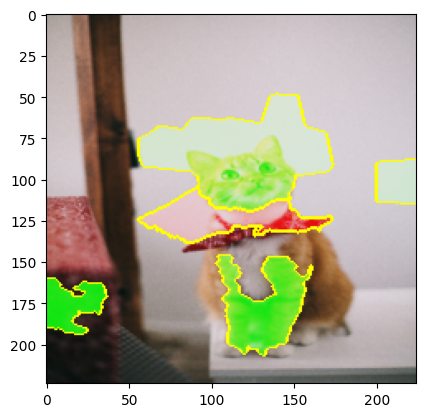

In [73]:
from skimage.segmentation import mark_boundaries #Return image with boundaries between labeled regions highlighted (https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries)

target_label = explanation.top_labels[0]

# showing both Positive & Negative superpixels
temp, mask = explanation.get_image_and_mask(label=target_label, 
                                            positive_only=False, # if True, only take superpixels that positively contribute to the prediction of the label.
                                            num_features=15, #  number of superpixels to include in explanation
                                            hide_rest=False  # if True, make the non-explanation part of the return image gray
                                            )
print("segments",mask.shape)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

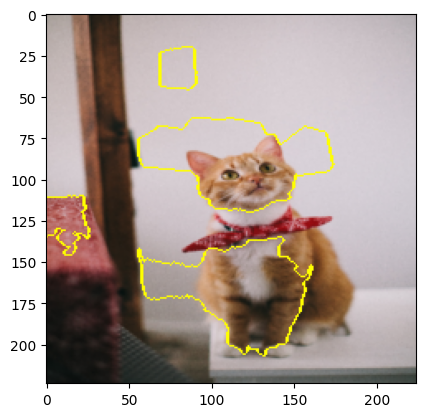

In [59]:
target_label = explanation.top_labels[0]

# showing only positve
temp, mask = explanation.get_image_and_mask(label=target_label,
                                            positive_only=True, 
                                            num_features=15, 
                                            hide_rest=False)

img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

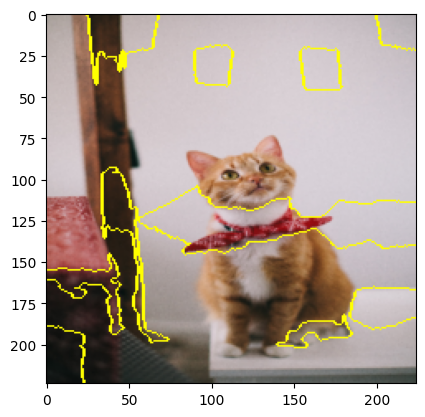

In [60]:
# showing only negative
temp, mask = explanation.get_image_and_mask(label=target_label,
                                            positive_only=False,
                                            negative_only=True, 
                                            num_features=15, 
                                            hide_rest=False)

img_boundry3 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry3)